# Modélisation de la variable énergie

**Rappel de l'objectif**

L'objectif de ce projet est de prédire les émissions de CO₂ ainsi que la consommation totale d'énergie des bâtiments non résidentiels de la ville de Seattle à partir de leurs caractéristiques structurelles (surface, usage, année de construction, localisation, etc.).  
Cette démarche s’inscrit dans l’objectif global de neutralité carbone fixé par la ville à l’horizon 2050.

**Contexte du notebook**

Dans ce notebook, nous allons préparer les données, entraîner des modèles et analyser les résultats liés à la prédiction de la consommation d'énergie.

Le jeu de données a été préalablement nettoyé et préparé dans le fichier `notebook_1.ipynb`.



## Sommaire

1. **Préparation des features pour la modélisation**
2. **Optimisation des hyperparamètres (GridSearchCV)**
3. **Évaluation avec le jeu de données de validation**
4. **Analyse de l'impact de ENERGYSTARScore**
5. **Conclusion et recommandations**

## Préparation des features pour la modélisation
### Configuration du notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import time
import seaborn as sns

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
	KFold
)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance
from sklearn.base import clone

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set(style="whitegrid")

# Constantes
TARGET_CO2 = 'GHGEmissionsIntensity'
TARGET_ENERGY = 'SiteEUIWN(kBtu/sf)'
CIBLES = [TARGET_ENERGY, TARGET_CO2]

TEST_SIZE = 0.2
RANDOM_STATE = 42
N_SPLITS = 5 # Choix standard pour la validation croisée


# Chargement des données
df_origin = pd.read_csv('data/data_train_test_clean.csv')

df = df_origin.copy()

print("📊 Dataset chargé")
print(f"   Shape : {df.shape}")
print(f"   Lignes : {len(df):,} bâtiments")
print(f"   Colonnes : {df.shape[1]}")
df.info()


📊 Dataset chargé
   Shape : (1151, 29)
   Lignes : 1,151 bâtiments
   Colonnes : 29
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1151 entries, 0 to 1150
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   BuildingType                     1151 non-null   object 
 1   PrimaryPropertyType              1151 non-null   object 
 2   Neighborhood                     1151 non-null   object 
 3   NumberofBuildings                1151 non-null   int64  
 4   NumberofFloors                   1151 non-null   int64  
 5   ENERGYSTARScore                  744 non-null    float64
 6   SiteEUIWN(kBtu/sf)               1151 non-null   float64
 7   GHGEmissionsIntensity            1151 non-null   float64
 8   num_years_certified              1151 non-null   int64  
 9   num_property_uses                1151 non-null   int64  
 10  use_type_gfa_residual            1151 non-null   float64
 11

### Composition de X et y

`X` regroupe l’ensemble des features, à l’exception de `ENERGYSTARScore`, ainsi que les deux variables cibles.  
Nous testerons dans un second temps l’ajout de `ENERGYSTARScore` afin d’évaluer son impact sur les performances du modèle.

`y` correspond à la variable cible `SiteEUIWN(kBtu/sf)`.  
La variable `GHGEmissionsIntensity` sera quant à elle modélisée et analysée dans un autre notebook.

In [2]:
def split_features_targets(df: pd.DataFrame, columns_to_drop: List[str], target: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Sépare les features et la variable cible.
    
    Parameters
    ----------
    df : DataFrame contenant toutes les colonnes
    columns_to_drop : colonnes à exclure des features
    target : nom de la variable cible
    
    Returns
    -------
    X : DataFrame des features
    y : Series de la variable cible
    """
    X = df.drop(columns=columns_to_drop)
    y = df[target]
    return X, y

X, y = split_features_targets(df, CIBLES + ['ENERGYSTARScore'], TARGET_ENERGY)

assert X.isna().sum().sum() == 0, "Valeurs manquantes détectées dans X"
assert y.isna().sum() == 0, "Valeurs manquantes détectées dans y"

print(f"X : {X.shape}")
print(f"y : {y.shape}")



X : (1151, 26)
y : (1151,)


### Encodage des variables catégorielles

Transformer les variables catégorielles en variables numériques pour que les algorithmes de Machine Learning puissent les utiliser.

**LabelEncoder** : transforme chaque catégorie textuelle en un entier unique, mais introduit un ordre artificiel entre les catégories, ce qui peut biaiser le modèle si les catégories ne sont pas ordinales.

**OneHotEncoder** : transforme une variable catégorielle en plusieurs variables binaires (0/1), cela évite d'introduire une relation d'ordre artificielle qui pourrait biaiser les modèles sensibles à l'ordre des valeurs

In [3]:
def identify_feature_types(X: pd.DataFrame) -> Tuple[List[str], List[str]]:
    """Identifie les features catégorielles et numériques dans un DataFrame."""
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    return categorical_features, numeric_features

X_categorical, X_numeric = identify_feature_types(X)

print(f"\nDimensions de X AVANT encodage : {X.shape}")
print(f"  • Features numériques : {len(X_numeric)}")
print(f"  • Features catégorielles : {len(X_categorical)}")

# Calcul du nombre de catégories uniques par variable
n_categories = (
    df[X_categorical]
    .nunique()
    .reset_index()
)

n_categories.columns = ["Variable", "Nombre_de_categories"]


Dimensions de X AVANT encodage : (1151, 26)
  • Features numériques : 23
  • Features catégorielles : 3


#### Stratégie d'encodage

- **BuildingType (4)** : OneHotEncoder, car il y a peu de catégories et aucun ordre naturel.
- **Neighborhood (13)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.
- **PrimaryPropertyType (21)** : OneHotEncoder, car le nombre de catégories reste raisonnable et aucun ordre naturel.


### Prétraitement des données

Avant d’entraîner le modèle, il est nécessaire de préparer les données afin qu’elles soient exploitables efficacement.

- **StandardScaler** : StandardScaler est un outil de normalisation qui applique la standardisation par z-score aux variables numériques. La standardisation facilite l'interprétation des coefficients et est essentielle pour les algorithmes sensibles à l'échelle comme

- **ColumnTransformer** : permet d’appliquer des transformations différentes selon les colonnes du dataset. Ici, les variables numériques sont standardisées avec `StandardScaler`, tandis que les variables catégorielles sont encodées avec `OneHotEncoder`, le tout dans une seule étape cohérente et reproductible.


In [4]:
# Créer un preprocessor avec ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical)
    ]
)


### Modèles
Voici les différents modèles choisie :

- **Dummy** : Modèle de référence basique qui prédit toujours la moyenne des valeurs cibles, utilisé comme baseline pour évaluer les performances des autres modèles.

- **LinearRegression** : Modèle de régression linéaire qui établit une relation linéaire entre les variables d'entrée et la variable cible en minimisant l'erreur quadratique.

- **SVR** : Support Vector Regression, qui utilise les concepts des machines à vecteurs de support pour effectuer une régression en trouvant un hyperplan optimal dans un espace de grande dimension.

- **RandomForestRegressor** : Ensemble d'arbres de décision qui combine les prédictions de multiples arbres pour améliorer la précision et réduire le surapprentissage.


La classe Pipeline de scikit-learn permet de chaîner les étapes de transformation des données et l’estimateur final au sein d’un seul objet, garantissant que chaque transformation est apprise exclusivement sur les données d’entraînement, notamment lors de la validation croisée.

In [5]:
models = {
    "Dummy": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DummyRegressor(strategy="mean"))
    ]),
    "LinearRegression": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]),
    "SVR":  Pipeline([
        ('preprocessor', preprocessor),
        ('model', SVR())
    ]),
    "RandomForest": Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=RANDOM_STATE))
    ])
}

### Métriques

La **MAE (Mean Absolute Error)** mesure l'écart moyen entre les prédictions et les valeurs réelles, en prenant la valeur absolue des erreurs. Elle est simple à interpréter, mais ne différencie pas entre les petites et les grandes erreurs.

Le **RMSE (Root Mean Squared Error)** met en valeur les grandes erreurs en les élevant au carré avant de calculer la racine carrée. Il est donc plus sensible aux prédictions extrêmes que la MAE.

Le **R²** évalue la performance du modèle par rapport à un modèle de base (Dummy Regressor) et peut varier de 1 (parfait) à des valeurs négatives (pire que la moyenne). Il n'est pas un pourcentage et peut être trompeur sans contexte.

L'utilisation conjointe de ces trois métriques permet :
- MAE : interprétabilité directe (erreur moyenne en unité de la cible)
- RMSE : sensibilité aux grandes erreurs
- R² : comparaison avec le modèle baseline

### Validation croisée

In [6]:
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [7]:
def train_and_evaluate_model_cv(model, X_train, y_train, cv):
    """
    Évalue un modèle de régression par validation croisée, puis entraîne
    le modèle sur l'ensemble du jeu d'entraînement.

    La fonction effectue une validation croisée afin de calculer les
    performances moyennes sur les folds (train et validation) pour
    plusieurs métriques, mesure le temps d'exécution total, puis ajuste
    le modèle sur toutes les données d'entraînement.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression compatible scikit-learn implémentant les
        méthodes `fit` et `predict`.

    X_train : array-like of shape (n_samples, n_features)
        Données d'entraînement.

    y_train : array-like of shape (n_samples,)
        Variable cible associée aux données d'entraînement.

    cv : int or cross-validation generator
        Stratégie de validation croisée (par exemple nombre de folds
        ou objet `KFold`, `StratifiedKFold`, etc.).

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2_cv_train : float
            Score R² moyen sur les folds d'entraînement.
        - mae_cv_train : float
            MAE moyenne sur les folds d'entraînement.
        - rmse_cv_train : float
            RMSE moyenne sur les folds d'entraînement.
        - r2_cv_test : float
            Score R² moyen sur les folds de validation.
        - mae_cv_test : float
            MAE moyenne sur les folds de validation.
        - rmse_cv_test : float
            RMSE moyenne sur les folds de validation.
        - r2_train_test_gap : float
            Différence entre le R² moyen train et validation.
        - duration : float
            Temps total d'exécution en secondes.
        - model_fitted : estimator scikit-learn
            Modèle entraîné sur l'ensemble du jeu d'entraînement.
    """
    start = time.time()
    # Entraîner le modèle sur toutes les données d'entraînement
    model_fitted = clone(model)

    # Validation croisée sur le jeu d'entraînement
    cv_results = cross_validate(
        model_fitted,
        X_train,
        y_train,
        cv=cv,
        scoring={
            "r2": "r2",                         # Coefficient de détermination R²
            "mae": "neg_mean_absolute_error",   # Erreur absolue moyenne (négative par convention sklearn)
            "rmse": "neg_root_mean_squared_error"  # Racine de l'erreur quadratique moyenne (négative)
        },
        # Retourne également les scores sur les folds d'entraînement
        # Utile pour détecter l'overfitting ou l'underfitting
        return_train_score=True,
        # Utilise tous les cœurs du processeur pour accélérer le calcul
        n_jobs=-1
    )

    model_fitted.fit(X_train, y_train)

    duration = time.time() - start

    # Moyennes des scores de validation croisée
    r2_cv_train = cv_results['train_r2'].mean()
    mae_cv_train = -cv_results['train_mae'].mean()
    rmse_cv_train = -cv_results['train_rmse'].mean()

    r2_cv_test = cv_results['test_r2'].mean()
    mae_cv_test = -cv_results['test_mae'].mean()
    rmse_cv_test = -cv_results['test_rmse'].mean()


    return {
        'r2_cv_train': r2_cv_train,
        'mae_cv_train': mae_cv_train,
        'rmse_cv_train': rmse_cv_train,
        'r2_cv_test': r2_cv_test,
        'mae_cv_test': mae_cv_test,
        'rmse_cv_test': rmse_cv_test,
        'r2_train_test_gap': r2_cv_train - r2_cv_test,
        'duration_cv': duration,
        'model_fitted': model_fitted
    }

In [8]:
def evaluate_model_validation(model, X_val, y_val, feature_names):
    """
    Évalue un modèle de régression entraîné sur un jeu de validation
    et calcule l'importance des variables par permutation.

    Paramètres
    ----------
    model : estimator scikit-learn
        Modèle de régression déjà entraîné implémentant les méthodes
        `predict`.

    X_val : array-like of shape (n_samples, n_features)
        Données de validation.

    y_val : array-like of shape (n_samples,)
        Valeurs cibles du jeu de validation.
    
    feature_names : array-like
        Noms des features pour le DataFrame d'importance.

    Retours
    -------
    results : dict
        Dictionnaire contenant :
        - r2 : float
            Score R² sur le jeu de validation.
        - mae : float
            Erreur absolue moyenne (MAE) sur le jeu de validation.
        - rmse : float
            Racine de l'erreur quadratique moyenne (RMSE) sur le jeu de validation.
        - importance_df : pandas.DataFrame
            DataFrame contenant l'importance moyenne et l'écart-type
            de chaque variable calculés par permutation, trié par
            importance décroissante.
    """
    start = time.time()

    y_pred = model.predict(X_val)

    duration = time.time() - start

    # Calcul de l'importance des variables par permutation
    perm_importance = permutation_importance(
        model,
        X_val,
        y_val,
        n_repeats=10, # Nombre de permutations aléatoires par variabl
        random_state=RANDOM_STATE, # Aléatoire pour garantir la reproductibilité des résultats
        n_jobs=-1, # Utilise tous les cœurs du processeur pour accélérer le calcul
        scoring='neg_mean_absolute_error' # Métrique utilisée pour mesurer la dégradation des performances
    )

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)

    return {
        'r2': r2_score(y_val, y_pred),
        'mae': mean_absolute_error(y_val, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
        'duration': duration,
        'importance_df': importance_df
    }

In [9]:
def annotate_bars(ax, fmt="{:.2f}", padding=3):
    for container in ax.containers:
        ax.bar_label(container, fmt=fmt, padding=padding)

def plot_bar(
    df,
    x,
    y,
    ax,
    title=None,
    xlabel=None,
    ylabel=None,
    palette=None,
    rotation=45,
    annotate=True
):
    sns.barplot(data=df, x=x, y=y, hue=x, palette=palette, ax=ax)


    ax.set_title(title if title else f"{y} par {x}")
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis="x", rotation=rotation)

    if annotate:
        annotate_bars(ax)
        # Augmenter ylim pour laisser de l'espace aux annotations
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.15 if ymax > 0 else ymax * 0.85)


def plot_metric_comparison(
    df,
    id_col,
    metrics,
    value_name,
    ax,
    title,
    xlabel="Modèle",
    rotation=45,
    annotate=True
):
    df_melt = df.melt(
        id_vars=id_col,
        value_vars=metrics,
        var_name="Metric",
        value_name=value_name
    )

    sns.barplot(
        data=df_melt,
        x=id_col,
        y=value_name,
        hue="Metric",
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.tick_params(axis="x", rotation=rotation)
    ax.legend(title="Métrique")

    if annotate:
        annotate_bars(ax)
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax * 1.15)


In [10]:
results_all_models  = []

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

feature_names = X_test.columns.tolist()

for model_name, model in models.items():
    print(f"\nModèle en cours : {model_name}")
    results_cv = train_and_evaluate_model_cv(model, X_train, y_train, kfold)
    results_val = evaluate_model_validation(results_cv['model_fitted'], X_test, y_test, feature_names)
    results = {
        'model_name': model_name,
        **results_val,
        **results_cv
    }
    results_all_models .append(results)


Modèle en cours : Dummy

Modèle en cours : LinearRegression

Modèle en cours : SVR

Modèle en cours : RandomForest


Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap,duration_cv
0,Dummy,0.00,-0.00,36.44,50.94,0.00,2.20
1,LinearRegression,0.43,0.27,30.34,42.87,0.16,0.25
2,SVR,0.04,0.02,32.76,50.22,0.02,0.25
3,RandomForest,0.90,0.27,30.36,43.20,0.63,2.48


Métriques sur jeu de test final


,model_name,r2,mae,rmse,duration
0,Dummy,-0.00,40.60,57.03,0.00
1,LinearRegression,0.36,32.09,45.58,0.01
2,SVR,0.02,36.06,56.44,0.03
3,RandomForest,0.41,30.55,43.76,0.04


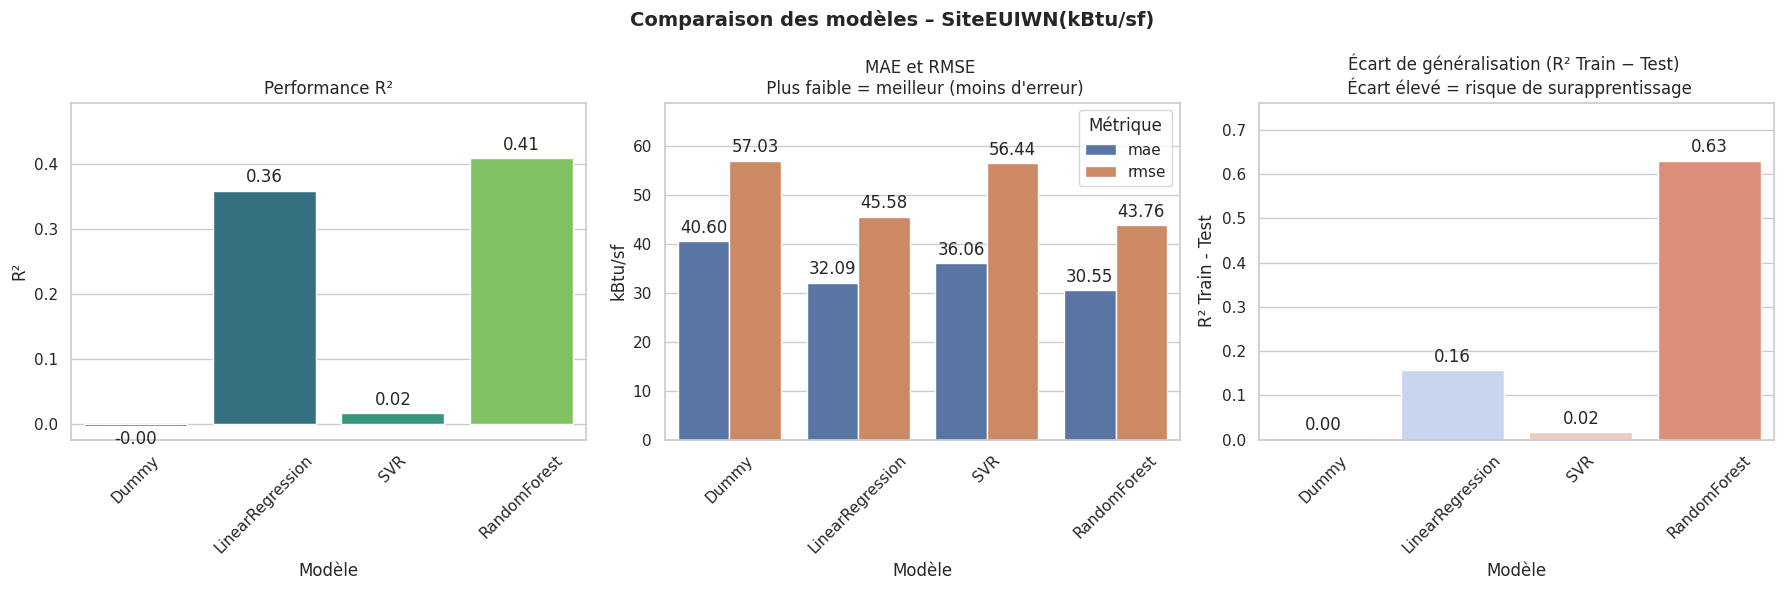

In [11]:
def display_results_models(results_list: List[dict], columns_to_show : List[str] = []):
    df = pd.DataFrame(results_list)
    display(df[columns_to_show].round(2))


def plot_model_comparison(results_all_models, suptitle):
    df_models = pd.DataFrame(results_all_models)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(
        suptitle,
        fontsize=14,
        fontweight="bold"
    )

    # R²
    plot_bar(
        df_models,
        x="model_name",
        y="r2",
        ax=axes[0],
        ylabel="R²",
        title="Performance R²",
        palette="viridis",
        xlabel="Modèle"
    )

    # MAE Train / Test
    plot_metric_comparison(
        df_models,
        id_col="model_name",
        metrics=["mae", "rmse"],
        value_name="kBtu/sf",
        ax=axes[1],
        title="MAE et RMSE \n Plus faible = meilleur (moins d'erreur)",
        xlabel="Modèle"
    )

    # Overfitting gap
    plot_bar(
        df_models,
        x="model_name",
        y="r2_train_test_gap",
        ax=axes[2],
        ylabel="R² Train - Test",
        title="Écart de généralisation (R² Train − Test) \n Écart élevé = risque de surapprentissage",
        palette="coolwarm",
        xlabel="Modèle"
    )

    plt.tight_layout()
    plt.show()


print("Métriques de validation croisée")
display_results_models(results_all_models, ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap', 'duration_cv'])
print("Métriques sur jeu de test final")
display_results_models(results_all_models, ['model_name', 'r2', 'mae', 'rmse', 'duration'])

plot_model_comparison(results_all_models, f"Comparaison des modèles – {TARGET_ENERGY}")

**Observations**

Le modèle Dummy obtient un R² proche de 0, confirmant son rôle de simple baseline.

Le SVR obtient un R² proche de 0, ce qui signifie qu'ils ne parviennent pas à expliquer correctement la variable à prédire. Cela peut s'expliquer par les paramètres par défaut qui ne sont pas adaptés à ce jeu de données.

En validation croisée, le RandomForest et la régression linéaire obtiennent un R² similaire (0.27). En revanche, sur le jeu de test, le RandomForest affiche un R² légèrement supérieur (0.41 contre 0.36) ainsi que des erreurs (MAE et RMSE) plus faibles.

Cependant, le RandomForest présente un surapprentissage important : son R² en entraînement atteint 0.90 contre 0.27 en validation croisée, soit un écart de 0.63. À titre de comparaison, la régression linéaire a un écart de seulement 0.16, ce qui indique une meilleure stabilité.

**Choix du modèle**

Nous choisissons le modèle RandomForest, car il obtient les meilleures performances sur le jeu de test parmi les modèles évalués. Une optimisation des hyperparamètres sera réalisée afin de réduire le surapprentissage observé et d'améliorer sa capacité de généralisation.


## Optimisation des hyperparamètres (GridSearchCV)

Afin d’améliorer les performances du modèle **RandomForest**, nous utilisons un **GridSearchCV** en ajustant plusieurs hyperparamètres clés. L’objectif principal est de **réduire le surapprentissage**, identifié lors de l’étape d’évaluation des modèles.

**GridSearchCV** est une fonction qui permet à la fois d'implémenter une validation croisée et de sélectionner les paramètres optimaux du modèle.

`n_estimators` — Nombre d'arbres
- Plus le nombre d'arbres est élevé, plus le modèle est stable
- Les prédictions sont moyennées, ce qui réduit la variance

`max_depth` — Profondeur maximale des arbres
- Limite la complexité de chaque arbre
- Empêche l'apprentissage de règles trop spécifiques aux données d'entraînement

`min_samples_split` — Minimum d'exemples pour diviser un nœud
- Empêche la création de splits basés sur trop peu d'observations
- Réduit les décisions instables ou peu représentatives

`min_samples_leaf` — Minimum d'exemples par feuille
- Force chaque prédiction finale à reposer sur un nombre suffisant d'exemples
- Améliore la stabilité et la capacité de généralisation du modèle

`max_features` — Nombre de features considérées pour chaque split
- Introduit de la randomisation en limitant les variables disponibles à chaque division
- 'sqrt' utilise la racine carrée du nombre total de features, 0.5 en utilise la moitié
- Réduit la corrélation entre les arbres et améliore la diversité de l'ensemble


In [12]:
def gridsearch_random_forest(X_train, y_train, kfold, param_grid):
    """
    Optimise les hyperparamètres d'un RandomForest via GridSearchCV.
    
    Retour
    ------
    dict avec structure standardisée + best_params et best_model
    """
    start = time.time()
    pipe = Pipeline([
        ('preprocessor', preprocessor),   # votre ColumnTransformer existant
        ('model', RandomForestRegressor(random_state=RANDOM_STATE))
    ])
    grid_rf = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        cv=kfold,
        scoring= {
            'r2': 'r2',
            'mae': 'neg_mean_absolute_error',
            'rmse': 'neg_root_mean_squared_error'
        },
        refit='r2',
        n_jobs=-1,
        return_train_score=True
    )

    grid_rf.fit(X_train, y_train)

    duration = time.time() - start

    best_idx = grid_rf.best_index_
    cv = grid_rf.cv_results_

    return {
        "best_model": grid_rf.best_estimator_,
        "best_params": grid_rf.best_params_,
        "best_cv_r2": grid_rf.best_score_,
        'r2_cv_train': cv['mean_train_r2'][best_idx],
        'r2_cv_test': cv['mean_test_r2'][best_idx],
        'r2_train_test_gap': (
            cv['mean_train_r2'][best_idx] - cv['mean_test_r2'][best_idx]
        ),

        'mae_cv_train': -cv['mean_train_mae'][best_idx],
        'mae_cv_test': -cv['mean_test_mae'][best_idx],

        'rmse_cv_train': -cv['mean_train_rmse'][best_idx],
        'rmse_cv_test': -cv['mean_test_rmse'][best_idx],
        'duration': duration
    }

In [13]:
param_grid_rf = {
    'model__n_estimators': [200, 500, 700],
    'model__max_depth': [10, 12, 18, 25],
    'model__min_samples_split': [5, 10, 15],
    'model__min_samples_leaf': [3, 5, 8],
    'model__max_features': ['sqrt', 0.5, 0.7]
}


results_gridsearch = gridsearch_random_forest(
    X_train,
    y_train,
    kfold,
    param_grid_rf
)

results_val_best_model = evaluate_model_validation(results_gridsearch['best_model'], X_test, y_test, feature_names)


📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST
Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,Random Forest (baseline),0.9,0.27,30.36,43.20,0.63
1,Random Forest optimisé,0.6,0.28,30.08,42.97,0.32


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,Random Forest (baseline),0.41,30.55,43.76
1,Random Forest optimisé,0.41,30.51,43.83



🔧 MEILLEURS PARAMÈTRES PAR CIBLE

{'model__max_depth': 12, 'model__max_features': 0.7, 'model__min_samples_leaf': 3, 'model__min_samples_split': 5, 'model__n_estimators': 700}


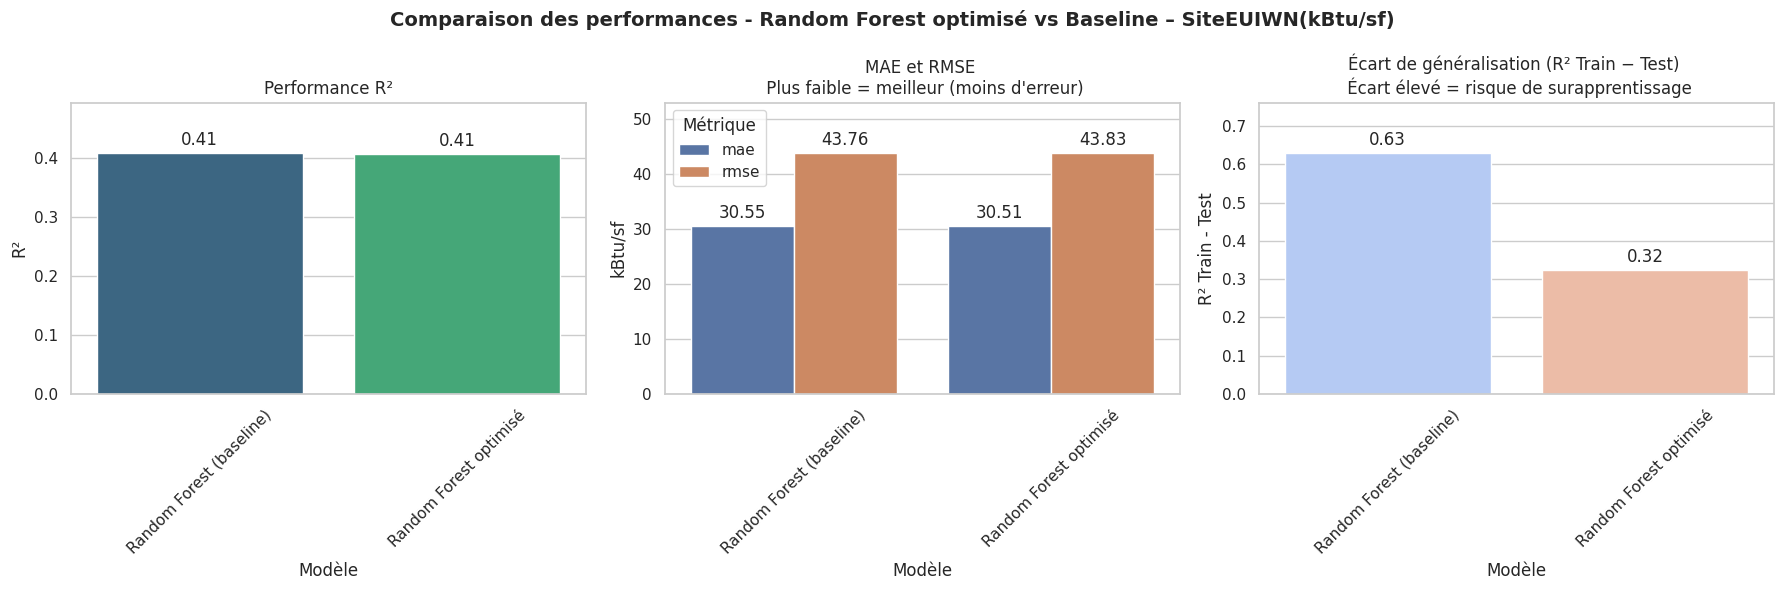

In [14]:
results_best_model = {
    'model_name': "Random Forest optimisé",
    **results_val_best_model,
    **results_gridsearch
}

rf_baseline = next(
    r for r in results_all_models
    if r["model_name"] == "RandomForest"
).copy()

rf_baseline["model_name"] = "Random Forest (baseline)"


print("\n" + "="*80)
print("📊 RÉSULTATS FINAUX - MEILLEURS MODÈLES RANDOM FOREST")
print("="*80)

print("Métriques de validation croisée")
display_results_models([rf_baseline, results_best_model], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_baseline, results_best_model], ['model_name', 'r2', 'mae', 'rmse'])
print("\n🔧 MEILLEURS PARAMÈTRES PAR CIBLE\n")
print(results_best_model['best_params'])

plot_model_comparison([rf_baseline, results_best_model], f"Comparaison des performances - Random Forest optimisé vs Baseline – {TARGET_ENERGY}")

**Observations**

L'optimisation des hyperparamètres a permis de réduire le surapprentissage.

**Analyse du compromis biais-variance :**
- Le R² d'entraînement est passé de 0.90 à 0.60, ce qui est **souhaitable** : le modèle mémorise moins les données d'entraînement
- Le gap train/test a été réduit de 0.63 à 0.32, indiquant une **meilleure généralisation**
- Le R² sur le jeu de test (0.41), la MAE (30.51) et le RMSE (43.83) restent stables, ce qui signifie que le modèle n'a pas perdu en performance malgré la régularisation

**Paramètres optimaux retenus :**
- `max_depth=12` : limite la profondeur des arbres pour éviter les règles trop spécifiques
- `min_samples_leaf=3` et `min_samples_split=5` : imposent un minimum d'observations par nœud
- `max_features=0.7` : introduit de la diversité entre les arbres
- `n_estimators=700` : nombre d'arbres suffisant pour stabiliser les prédictions

Le modèle optimisé présente un meilleur équilibre entre apprentissage et généralisation.


## Evaluation avec le jeu de donnée de validation

Le jeu de validation provient du **split initial réalisé dans le notebook 1** :
- Split stratifié 80/20 effectué **avant** tout prétraitement
- 80% → entraînement et test (ce notebook)
- 20% → validation finale (fichier `data_val_clean_with_energystart.csv`)

Ce jeu n'a **jamais été utilisé** durant la phase d'entraînement ou d'optimisation des hyperparamètres. Il permet d'évaluer la capacité de généralisation réelle du modèle sur des données totalement inédites.

Le même pipeline de nettoyage et de feature engineering a été appliqué aux deux jeux de données pour garantir la cohérence.

In [15]:
# Charger les données de validation
data_val = pd.read_csv('data/data_val_clean.csv')  # Adaptez le chemin

# Séparer les features et les cibles
X_val, y_val = split_features_targets(data_val, CIBLES + ['ENERGYSTARScore'], TARGET_ENERGY)

results_validation = evaluate_model_validation(results_best_model['best_model'], X_val, y_val, X_val.columns.tolist())

results_validation = {
	'model_name' : "RF Optimisé (validation)",
	**results_validation
}



,model_name,r2,mae,rmse
0,Random Forest optimisé,0.41,30.51,43.83
1,RF Optimisé (validation),0.46,24.15,32.91


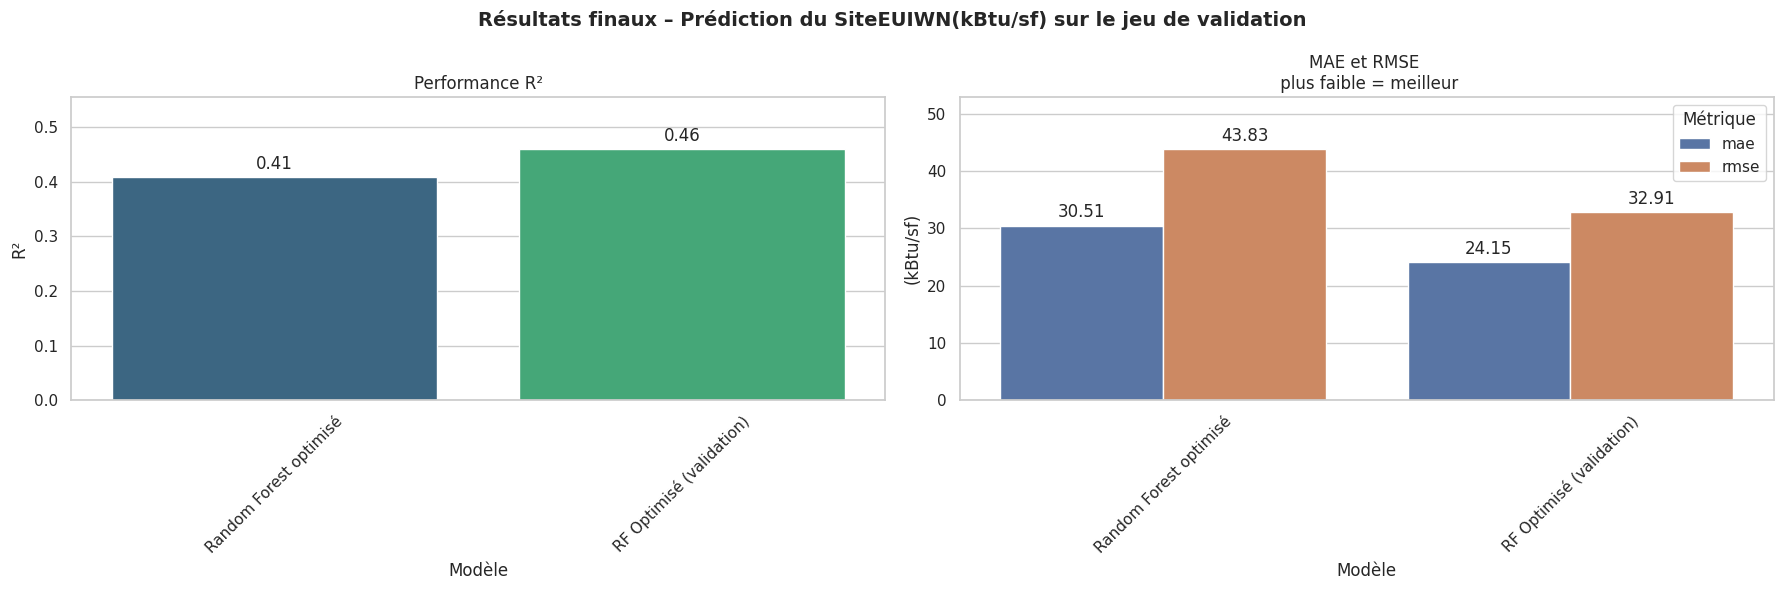

In [ ]:
display_results_models([results_best_model, results_validation], ['model_name', 'r2', 'mae', 'rmse'])

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle(
    f"Résultats finaux – Prédiction du {TARGET_ENERGY} sur le jeu de validation",
    fontsize=14,
    fontweight="bold"
)

# R²
plot_bar(
    pd.DataFrame([results_best_model, results_validation]),
    x="model_name",
    y="r2",
    ax=axes[0],
    ylabel="R²",
	xlabel="Modèle",
    title="Performance R²",
    palette="viridis"
)

# MAE Train / Test
plot_metric_comparison(
    pd.DataFrame([results_best_model, results_validation]),
    id_col="model_name",
    metrics=["mae", "rmse"],
    value_name="(kBtu/sf)",
    ax=axes[1],
    title="MAE et RMSE \n plus faible = meilleur",
	xlabel="Modèle",
)

plt.tight_layout()
plt.show()

**Observation**

Les performances sur le jeu de validation finale sont supérieures à celles observées sur le jeu de test :

| Jeu de données | R² | MAE (kBtu/sf) | RMSE (kBtu/sf) |
|----------------|-----|-----|------|
| Test (20%) | 0.41 | 30.51 | 43.83 |
| Validation finale | 0.46 | 24.15 | 32.91 |

**Interprétation :**

Cette différence peut s'expliquer par plusieurs facteurs :
1. **Variabilité des échantillons** : avec des jeux de données de taille modeste, les performances peuvent varier selon la composition de l'échantillon
2. **Distribution des données** : le jeu de validation peut contenir des bâtiments avec des caractéristiques plus homogènes ou plus proches des patterns appris
3. **Moins de valeurs extrêmes** : le RMSE nettement plus faible (32.91 vs 43.83) suggère moins d'erreurs importantes sur ce jeu

**Conclusion :** Le modèle généralise correctement sur des données totalement inédites, avec environ 46% de la variance expliquée.


🔝 Top 10 des features - SiteEUIWN(kBtu/sf)


,feature,importance_mean,importance_std
0,BuildingType,0.142133,0.104464
13,parking_ratio,0.187808,0.125633
12,decade_built,0.199089,0.063107
25,has_supermarket,0.217769,0.079370
2,Neighborhood,0.245300,0.156652
4,NumberofFloors,0.257680,0.093396
10,energy_source_diversity,0.540344,0.221315
11,building_age,0.772502,0.204637
20,has_laboratory,0.940043,0.328256
1,PrimaryPropertyType,9.626122,0.436242


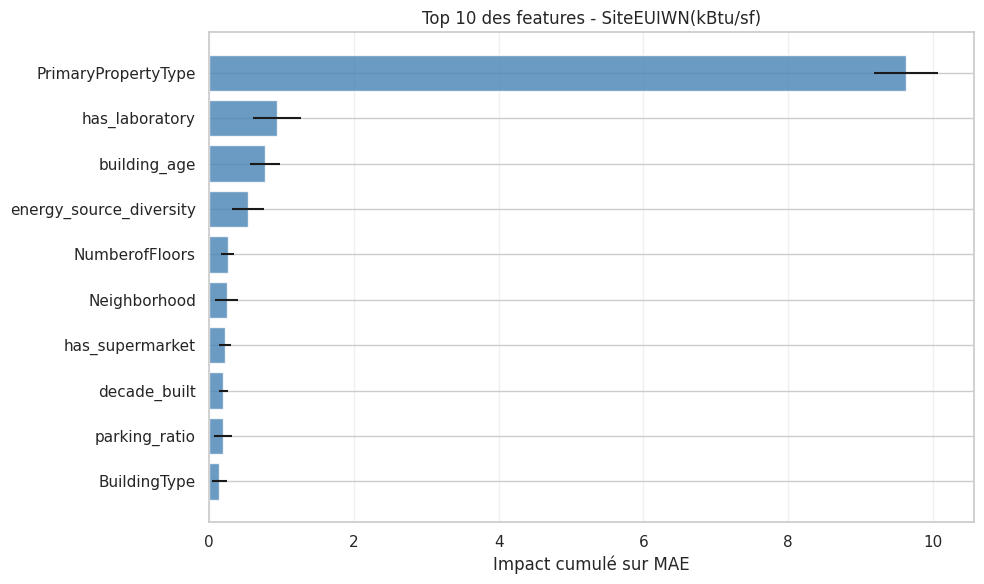

In [18]:
def display_features(importance_df, target_name, top_n=10):
    """
    Affiche les features importantes avec nettoyage et agrégation.
    """
    if importance_df.empty:
        print("⚠️ Aucune donnée d'importance disponible")
        return
    
    df = importance_df.copy()

    # Top N et tri
    df = df.nlargest(top_n, 'importance_mean').sort_values('importance_mean')
    
    # Affichage
    print("\n" + "="*70)
    print(f"🔝 Top {top_n} des features - {target_name}")
    print("="*70)
    display(df)
    
    # Graphique
    plt.figure(figsize=(10, max(6, top_n * 0.5)))
    plt.barh(df['feature'], df['importance_mean'], 
             xerr=df['importance_std'], alpha=0.8, color='steelblue')
    plt.xlabel('Impact cumulé sur MAE')
    plt.title(f'Top {top_n} des features - {target_name}')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

display_features(results_validation['importance_df'], TARGET_ENERGY, 10)

#### Variable dominante
- **PrimaryPropertyType** (importance : 9.63) — Le type d'usage du bâtiment domine largement toutes les autres variables. À lui seul, il représente environ **10× l'impact** de la deuxième variable. C'est le facteur déterminant de la consommation énergétique.

#### Variables d'importance secondaire
- **has_laboratory** (0.94) — La présence d'un laboratoire, usage très énergivore
- **building_age** (0.77) — L'âge du bâtiment, lié à la qualité d'isolation et aux équipements
- **energy_source_diversity** (0.54) — La diversité des sources d'énergie utilisées

Ces variables contribuent à affiner la prédiction, mais leur impact reste un ordre de grandeur en dessous du type d'usage.

#### Variables à impact limité
- **NumberofFloors** (0.26), **Neighborhood** (0.25), **has_supermarket** (0.22)
- **decade_built** (0.20), **parking_ratio** (0.19), **BuildingType** (0.14)

La localisation (Neighborhood), les indicateurs secondaires (parking, supermarché) et même le type de bâtiment (BuildingType, distinct du type d'usage) ont un impact marginal.

#### Interprétation générale
La consommation énergétique des bâtiments non résidentiels dépend avant tout de **leur fonction principale** (bureau, hôpital, laboratoire, etc.), et beaucoup moins de leur emplacement ou de leurs caractéristiques secondaires. La présence d'usages très énergivores (laboratoire, supermarché) constitue le deuxième levier d'explication.

Ce déséquilibre dans l'importance des variables explique en partie les performances limitées du modèle : au-delà du type d'usage, les autres features apportent peu d'information supplémentaire pour prédire la consommation.


## Analyse de l'impact de ENERGYSTARScore


In [19]:
df_with_energystar = df_origin.copy()
df_with_energystar = df_with_energystar[df_with_energystar['ENERGYSTARScore'].notna()]
print(f"df_with_energystar : {df_with_energystar.shape}")


df_with_energystar : (744, 29)


Nous conservons uniquement les lignes avec une valeur non nulle pour ENERGYSTARScore, ce qui fait passer le dataset de 1 151 à 744 observations.

In [20]:
X_with_energystar, y_with_energystar = split_features_targets(df_with_energystar, CIBLES , TARGET_ENERGY)

X_categorical_with_es, X_numeric_with_es = identify_feature_types(X_with_energystar)

preprocessor_with_es = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_numeric_with_es),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_categorical_with_es)
    ]
)

In [21]:
results_with_es = []

X_train_es, X_test_es, y_train_es, y_test_es = train_test_split(
    X_with_energystar,
    y_with_energystar,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Retirer le préfixe 'model__' des best_params pour les passer au RandomForestRegressor
rf_params = {k.replace('model__', ''): v for k, v in results_best_model['best_params'].items()}

pipe_es = Pipeline([
    ('preprocessor', preprocessor_with_es),
    ('model', RandomForestRegressor(**rf_params, random_state=RANDOM_STATE))
])  

results_cv_with_es = train_and_evaluate_model_cv(pipe_es, X_train_es, y_train_es, kfold)
results_val_with_es = evaluate_model_validation(results_cv_with_es['model_fitted'], X_test_es, y_test_es, X_test_es.columns.tolist())
results_es = {
	'model_name' : "RF optimisé + ENERGYSTARScore",
	**results_val_with_es,
	**results_cv_with_es
}

Métriques de validation croisée


,model_name,r2_cv_train,r2_cv_test,mae_cv_test,rmse_cv_test,r2_train_test_gap
0,Random Forest (baseline),0.90,0.27,30.36,43.20,0.63
1,Random Forest optimisé,0.60,0.28,30.08,42.97,0.32
2,RF optimisé + ENERGYSTARScore,0.82,0.57,19.06,29.98,0.25


Métriques sur jeu de test final


,model_name,r2,mae,rmse
0,Random Forest (baseline),0.41,30.55,43.76
1,Random Forest optimisé,0.41,30.51,43.83
2,RF optimisé + ENERGYSTARScore,0.68,17.64,27.48


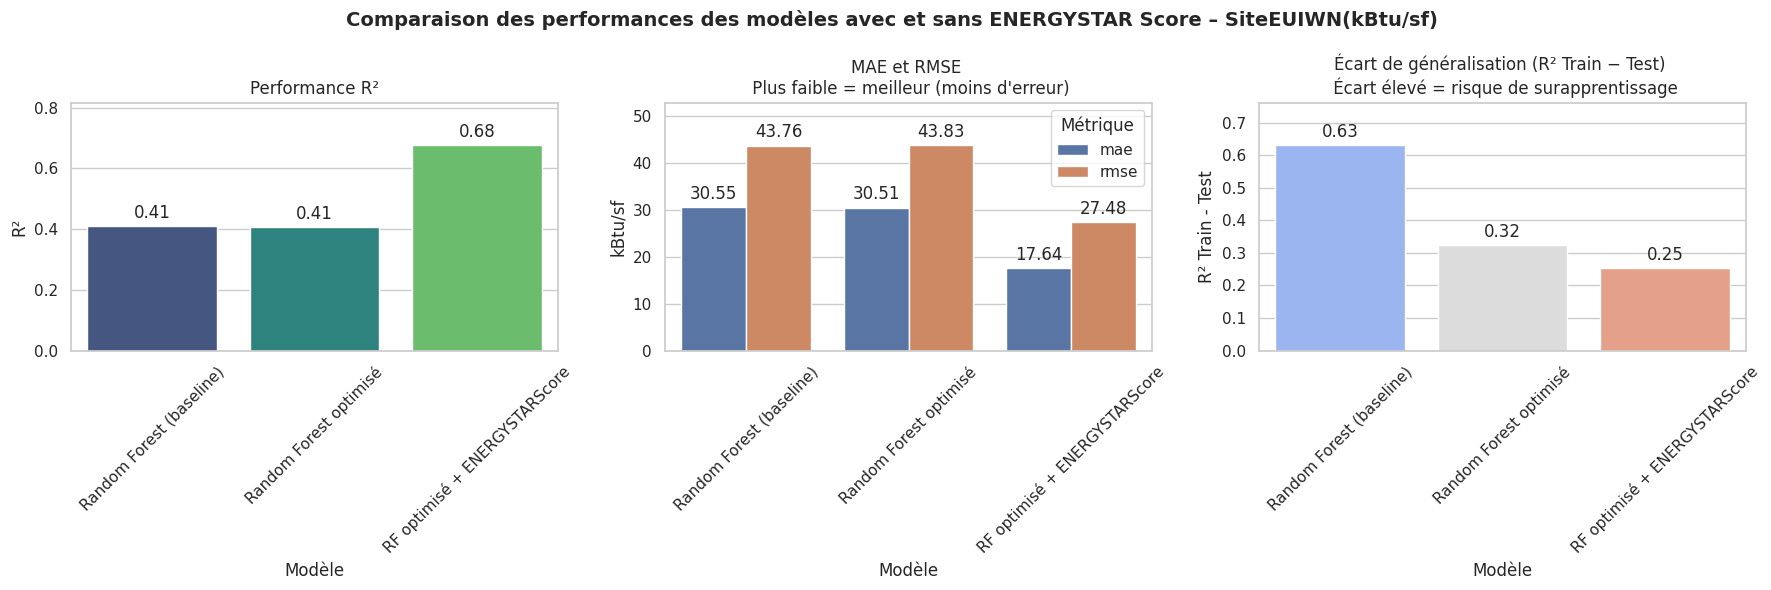

In [22]:
print("Métriques de validation croisée")
display_results_models([rf_baseline, results_best_model, results_es], ['model_name', 'r2_cv_train', 'r2_cv_test', 'mae_cv_test', 'rmse_cv_test', 'r2_train_test_gap'])
print("Métriques sur jeu de test final")
display_results_models([rf_baseline, results_best_model, results_es], ['model_name', 'r2', 'mae', 'rmse'])

plot_model_comparison([rf_baseline, results_best_model, results_es], f"Comparaison des performances des modèles avec et sans ENERGYSTAR Score – {TARGET_ENERGY}")

**Interprétation :**

L'ajout de la variable `ENERGYSTARScore` améliore considérablement les performances du modèle :

| Modèle | R² | MAE | RMSE | Gap train/test |
|--------|-----|-----|------|----------------|
| RFR Optimisé (sans ES) | 0.40 | 30.57	 | 43.94 | 0.32 |
| RFR avec ENERGYSTARScore | 0.67 | 17.66 | 27.68 | 0.24 |

**Analyse des résultats :**

1. **Amélioration spectaculaire** : le R² passe de 0.40 à 0.67, soit +67% de variance expliquée
2. **Réduction des erreurs** : la MAE diminue de 42% (30.57 → 17.66 kBtu/sf) et le RMSE est passer de 43.94 -> 27.68 (kBtu/sf)
3. **Meilleure généralisation** : le gap train/test passe de 0.37 à 0.25

## Conclusion et recommandations

### Synthèse de la démarche

Quatre modèles ont été entraînés (Dummy, Régression Linéaire, SVR, Random Forest) puis évalués par validation croisée à 5 folds. Le Random Forest a été retenu et optimisé via GridSearchCV, puis évalué sur un jeu de validation finale totalement indépendant.

### Résultats obtenus

| Modèle | R² (test) | MAE (kBtu/sf) | RMSE (kBtu/sf) | Gap train/test |
|--------|-----------|---------------|----------------|----------------|
| RF baseline | 0.41 | 30.55 | 43.76 | 0.63 |
| RF optimisé | 0.41 | 30.51 | 43.83 | 0.32 |
| RF optimisé (validation) | 0.46 | 24.15 | 32.91 | — |
| RF optimisé + ENERGYSTARScore | 0.68 | 17.64 | 27.48 | 0.25 |

**Sans ENERGYSTARScore**, le modèle optimisé explique environ **41 à 46%** de la variance de la consommation énergétique, avec une erreur absolue moyenne de **24 à 31 kBtu/sf**. L'optimisation des hyperparamètres n'a pas amélioré le pouvoir prédictif (R² stable à 0.41), mais a réduit significativement le surapprentissage (gap passant de 0.63 à 0.32).

**Avec ENERGYSTARScore**, les performances augmentent fortement (R² = 0.68, MAE = 17.64 kBtu/sf), mais cette variable n'est disponible que pour **65%** des bâtiments (744 sur 1151). De plus, cette comparaison est effectuée sur un sous-ensemble différent, ce qui limite la portée de la conclusion.

### Variables les plus influentes

Le **type d'usage principal** (PrimaryPropertyType) domine très largement, avec un impact environ **10 fois supérieur** à la deuxième variable. Les autres facteurs contributifs sont la présence d'un laboratoire, l'âge du bâtiment et la diversité des sources d'énergie. La localisation géographique a un impact marginal.

### Limites

- **Pouvoir prédictif modéré** : avec un R² autour de 0.41–0.46 sans ENERGYSTARScore, plus de la moitié de la variance reste inexpliquée. Les features structurelles disponibles ne suffisent pas à capturer toute la variabilité de la consommation énergétique.
- **Dépendance à ENERGYSTARScore** : la variable la plus discriminante est absente pour 35% des bâtiments, et son utilisation pose un problème de circularité (le score est lui-même calculé à partir de la consommation).
- **Taille du dataset** : avec 1 151 observations et des résultats variables entre test et validation, les métriques restent sensibles à la composition des échantillons.

### Recommandations

**Pour améliorer la modélisation :**
- Tester des algorithmes de boosting (XGBoost, LightGBM), généralement plus performants que le Random Forest sur ce type de données tabulaires
- Enrichir les features avec des données externes (taux d'occupation, type de système CVC)
- Réaliser la comparaison avec/sans ENERGYSTARScore **sur le même sous-ensemble de 744 lignes** pour isoler l'apport réel de cette variable

**Pour l'utilisation opérationnelle :**
- Privilégier le modèle avec ENERGYSTARScore lorsque le score est disponible
- Utiliser le modèle standard comme solution de repli pour les bâtiments sans score
- Concentrer les efforts de collecte de données sur le type d'usage détaillé des bâtiments, facteur le plus déterminant

La prédiction des émissions de CO₂ sera traitée dans un notebook dédié.
